In [1]:
import visa
from lantz import Feat
from lantz.core import mfeats
from lantz import MessageBasedDriver
from lantz.core import log
from logging import DEBUG

import numpy as np
import matplotlib.pyplot as plt


from lantz import Feat
from lantz.core import mfeats
from lantz import MessageBasedDriver#http://localhost:8888/notebooks/Downloads/SegundaClase-master/OsciGenerador.ipynb#
from lantz.core import log
from logging import DEBUG
import numpy as np
import time


class OsciloscopioTektronix1002B(MessageBasedDriver):

    MANUFACTURER_ID = '0x0699'
    MODEL_CODE = '0x0346'

    @Feat()
    def idn(self):
        return self.query('*IDN?')

    timebase = mfeats.QuantityFeat("HOR:MAI:SCA?","HOR:MAI:SCA {}", units = 's',limits=(0,10000))
    
    voltagescale = mfeats.QuantityFeat("CH1:SCA?","CH1:SCA {}", units = 'V',limits=(0,10))
    @property
    def canal(self):
        return self.__canal
    
    @canal.setter
    def canal(self, CH):  # def canal(self, CH, set_value = True):
        self.write('DAT:SOU CH{}'.format(str(CH)))
        #self.query('MEASU:IMM:SOU {}'.format(str(CH)))

    @canal.getter
    def canal(self):
        return self.query('DAT:SOU?')


    def pantalla(self):
        self.write('DAT:ENC RPB')
        self.write('DAT: WID 1')
        data = self.resource.query_binary_values('CURV?', datatype='B',  is_big_endian=True)
        time = np.arange(len(data))
        return time, data

    def escaleo(self):
        #self.inst.write('DAT:ENC ASCIi')
        #self.inst.write('DAT: WID 1')
        print(self.query('WFMP?'))

        #xze, xin, yze, ymu, yoff = self.inst.query_ascii_values('WFMPRE:XZE?;XIN?;YZE?;YMU?;YOFF?;')
        # return xze, xin, yze, ymu, yoff

    def escaleo2(self):
        self.write('DAT:ENC RPB')
        self.write('DAT: WID 1')
        xze, xin, yze, ymu, yoff = self.resource.query_ascii_values(
            'WFMP:XZE?;XIN?;YZE?;YMU?;YOF?;', separator=";")
        return xze, xin, yze, ymu, yoff


ImportError: 
    Could not load requested Qt binding. Please ensure that
    PyQt4 >= 4.7 or PySide >= 1.0.3 is available,
    and only one is imported per session.

    Currently-imported Qt library:   None
    PyQt4 installed:                 False
    PySide >= 1.0.3 installed:       False
    Tried to load:                   ['pyside', 'pyqt']
    

In [ ]:
class Generador(MessageBasedDriver):

    MANUFACTURER_ID = '0x0699'
    MODEL_CODE = '0x0346'

    @Feat()
    def idn(self):
        return self.query('*IDN?')
    
    @Feat(units = 'Hz',limits=(0,10000))
    def freq(self):
        self.log
        return float(self.query("SOUR1:FREQ:FIX?"))
        
    @freq.setter
    def freq(self, hertz):
        self.write("SOUR1:FREQ:FIX {}".format(hertz))
    
    freqs = mfeats.QuantityFeat("SOUR1:FREQ:FIX?","SOUR1:FREQ:FIX {}", units = 'Hz',limits=(0,10000))
        
    def set_amp(self, volts):
        self.write("SOUR1:VOLT:AMPL {}".format(volts))
   
    def waveform_shape(self, channel = 1, shape = 'SIN'):
        # Formas posibles: SIN, SQU, PULS, RAMP
        # PRNoise, DC|SINC|GAUSsian|LORentz|ERISe|EDECay|
        # HAVersine
        self.write('SOUR{}:FUNC:SHAPE {}'.format(channel, shape))
        
    def waveform_phase(self, radians, channel = 1):
        self.write('SOUR{}:PHAS {})'.format(channel, radians))
    
    def close_instrument(self):
        # Close VISA session (Close instrument connection)
        print("Killing")
        self.close()
        print("VISA session closed!")
    
    def freq_sweep(self, freq_inicial, freq_final, step, stop = 1, channel = 1):
        # Hace un barrido de frecuencias desde freq_inicial hasta freq_final
        # con un step. Entre cada cambio de frecuencia dejamos 1 segundo de
        # stop.
        frecuencias = np.arange(freq_inicial, freq_final, step)
        for elemento in frecuencias:
            self.write('SOUR{}:FREQ:FIX {}'.format(channel, elemento))
            time.sleep(stop)
            

#with AFG3021b('USB0::0x0699::0x0346::C036492::INSTR') as inst:
 #   print(inst.idn)

In [ ]:
rm = visa.ResourceManager()
rm.list_resources()
Osciloscopio = rm.list_resources()

print(Osciloscopio)

In [ ]:
gen = Generador('USB0::0x0699::0x0346::C033248::INSTR')
gen.initialize()
osci = OsciloscopioTektronix1002B('USB0::0x0699::0x0363::C108011::INSTR')
osci.initialize()

In [ ]:
gen.freqs = 100 #tiene el problema, de que el query ademas de hacer un write hace un read.

In [ ]:
time, data = osci.pantalla()
xze, xin, yze, ymu, yoff = osci.escaleo2()
data = np.array([float(i) for i in data])
time = np.array([float(i) for i in time])
data = -yoff*ymu + data*ymu 
time = xze + time * xin

In [ ]:
data1= data
time1 = time

In [ ]:
osci.canal = 1

In [ ]:
plt.plot(time1[1:600],data1[1:600])
plt.plot(time2[1:600],data2[1:600])

In [ ]:
np.savetxt('data1.txt',data1)
np.savetxt('time2.txt',time2)
np.savetxt('data2.txt',data2)
np.savetxt('time1.txt',time1)

In [ ]:
#osci.canal = 0
osci.query('DAT:SOU?')


In [ ]:
#Dependiendo que estamos levantando, grabar antes la data antes que se pise
rango = 10 #la cantidad de iteraciones que voy a tener.
paso = 100 # cada cuanto es el paso entre una frecuencia y la siguiente
times = np.zeros((rango,2500)) #La cantidad de columnas es la cantidad de datos que me tira el osci
datas = np.zeros((rango,2500)) # creo que era 2500, esto habria que chequearlo
for i in range(0,rango):
    gen.freqs = i*paso #tiene el problema, de que el query ademas de hacer un write hace un read.
    osci.timebase = (1/(i*paso))/5  #Que cada 5 cuadraditos del Osci, halla 1 onda completa. Se vera si se ajusta
    time, data = osci.pantalla() #levanto pantalla
    xze, xin, yze, ymu, yoff = osci.escaleo2()#levanto el escaleo
    datas = np.array([float(j) for j in data]) #transformo en float y en array
    times = np.array([float(j) for j in time])
    datas = -yoff*ymu + datas*ymu #hago la conversion del escaleo
    times = xze + times * xin
    mdata[:][i] = datas #Primer valor es fila, el segundo es columna
    mtime[:][i] = times
np.savetxt('Nombre barrido freq data',mdata, delimiter=' ') 
np.savetxt('Nombre barrido freq tiempo',mtime, delimiter=' ') 

In [ ]:
rango = 10 #la cantidad de iteraciones que voy a tener.
paso = 100 # cada cuanto es el paso entre una frecuencia y la siguiente
times = np.zeros((rango,2500)) #La cantidad de columnas es la cantidad de datos que me tira el osci
datas = np.zeros((rango,2500)) # creo que era 2500, esto habria que chequearlo
for i in range(0,rango):
    gen.set_amp( i*paso)  #tiene el problema, de que el query ademas de hacer un write hace un read.
    osci.voltagescale = (1/(i*paso))/5  #Que cada 5 cuadraditos del Osci, halla 1 onda completa. Se vera si se ajusta
    time, data = osci.pantalla() #levanto pantalla
    xze, xin, yze, ymu, yoff = osci.escaleo2()#levanto el escaleo
    datas = np.array([float(j) for j in data]) #transformo en float y en array
    times = np.array([float(j) for j in time])
    datas = -yoff*ymu + datas*ymu #hago la conversion del escaleo
    times = xze + times * xin
    mdata[:][i] = datas #Primer valor es fila, el segundo es columna
    mtime[:][i] = times
np.savetxt('Nombre barrido amp data',mdata, delimiter=' ') 
np.savetxt('Nombre barrido amp tiempo',mtime, delimiter=' ') 

In [2]:
entrada = [59.6,59.6,58.8,56.8,55.2,50.4,59.2,57.2,53.2]

In [9]:
len(entrada)

9

In [3]:
salida = [42.8,44.8,45.6,50.4,55.6,60,40.4,38.8,34.4]

In [10]:
f = [10000,15000,20000,50000,100000,200000,5000,1000,500]

In [14]:
import matplotlib.pyplot as plt
import numpy as np

In [17]:
cociente = []
for i in range(len(entrada)):
    coc = entrada[i]/salida[i]
    cociente.append(coc)

cociente

[1.3925233644859814,
 1.330357142857143,
 1.289473684210526,
 1.126984126984127,
 0.9928057553956835,
 0.84,
 1.4653465346534655,
 1.4742268041237114,
 1.5465116279069768]

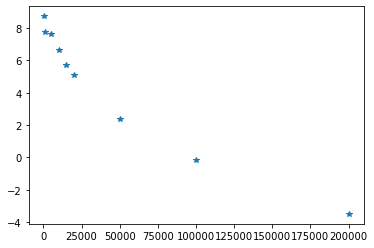

In [18]:
plt.plot(f,20*np.log(cociente),'*')